In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 4)

In [123]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [124]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

In [125]:
df = get_data()

In [126]:
df.columns

Index(['gdp_total', 'imports_goods_services', 'household_cons',
       'gov_consumption', 'investments', 'gpd_invest_business_households',
       'gov_invest', 'change_supply', 'exports_goods_services',
       'gdp_total_deseasonalized', 'imports_goods_services_deseasonalized',
       'household_cons_deseasonalized', 'gov_consumption_deseasonalized',
       'investments_deseasonalized',
       'gpd_invest_business_households_deseasonalized',
       'gov_invest_deseasonalized', 'change_supply_deseasonalized',
       'exports_goods_services_deseasonalized',
       'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7',
       'BeloningVanWerknemers_8', 'Netherlands_GDP', 'Germany_GDP',
       'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP'],
      dtype='object')

<Axes: >

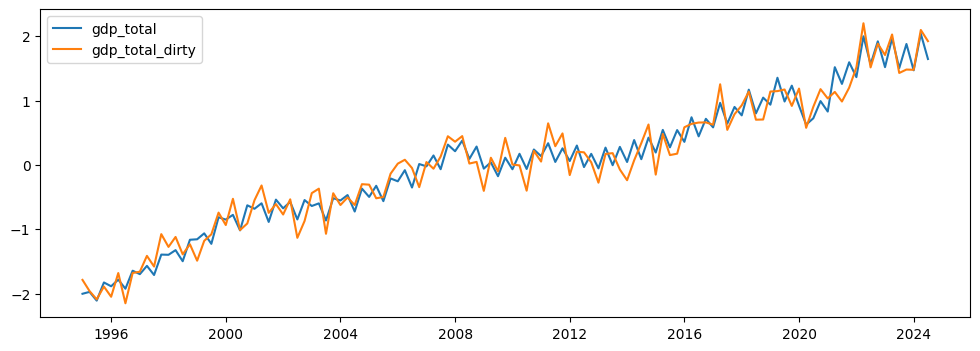

In [127]:
from sklearn.preprocessing import StandardScaler
import random


# subset of the data
df1 = df[[
        'gdp_total',
        'imports_goods_services',
        'household_cons',
        'gov_consumption', 
        'investments', 
        'gpd_invest_business_households',
        'gov_invest', 
        'change_supply', 
        'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

# create a sure-fire predictor
df1['gdp_total_dirty'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# scale data to make comparable
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)

scaled_features_df[['gdp_total','gdp_total_dirty']].plot()


In [128]:
scaled_features_df.head()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,gdp_total_deseasonalized,...,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty
1995-01-01,-2.002523,-1.641276,-2.632058,-1.669821,-1.840331,-1.572989,-2.732067,-0.622509,-1.550755,NaN,...,NaN,-1.700671,-1.719203,NaN,-1.826380,-1.956485,NaN,-2.268526,-1.836933,-1.786714
1995-04-01,-1.973273,-1.587921,-2.525192,-1.448865,-1.479140,-1.258953,-2.202548,-1.535684,-1.563031,NaN,...,NaN,-1.662912,-1.370268,NaN,-1.751343,-1.904910,NaN,-1.965803,-1.653072,-1.961002
1995-07-01,-2.108767,-1.653600,-2.437948,-1.812432,-2.072665,-1.830188,-2.593081,0.613523,-1.632568,NaN,...,NaN,-1.637459,-1.681575,NaN,-1.621475,-2.148884,NaN,-2.141781,-1.831052,-2.089468
1995-10-01,-1.826802,-1.598566,-2.622014,-1.492912,-1.293918,-1.236942,-1.041717,1.083540,-1.579339,NaN,...,NaN,-1.602870,-1.572195,NaN,-1.494491,-1.787402,NaN,-1.775144,-1.536782,-1.890560
1996-01-01,-1.886039,-1.567974,-2.228187,-1.745279,-1.842434,-1.562888,-2.809391,-0.369036,-1.485913,-2.113368,...,-1.64059,-1.618999,-1.646859,0.21731,-1.848506,-1.874681,-2.499954,-2.154475,-1.785378,-2.048991


[ 1  2  3  5  7  8 10 15 18 19 21 23 24 25]
['household_cons', 'gov_consumption', 'investments', 'gov_invest', 'exports_goods_services', 'gdp_total_deseasonalized', 'household_cons_deseasonalized', 'change_supply_deseasonalized', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'France_GDP', 'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty']


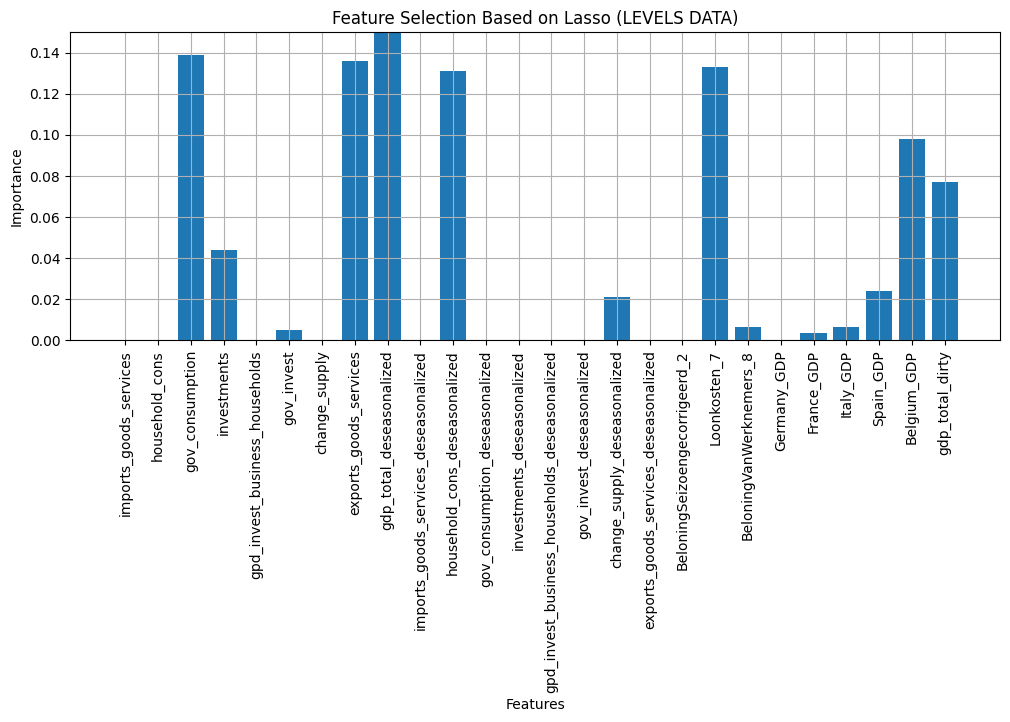

['household_cons',
 'gov_consumption',
 'investments',
 'gov_invest',
 'exports_goods_services',
 'gdp_total_deseasonalized',
 'household_cons_deseasonalized',
 'change_supply_deseasonalized',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'France_GDP',
 'Spain_GDP',
 'Belgium_GDP',
 'gdp_total_dirty']

In [129]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables


lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

[ 2  3  5 18 21 22 24 25]
['gov_consumption', 'investments', 'gov_invest', 'Loonkosten_7', 'France_GDP', 'Italy_GDP', 'Belgium_GDP', 'gdp_total_dirty']


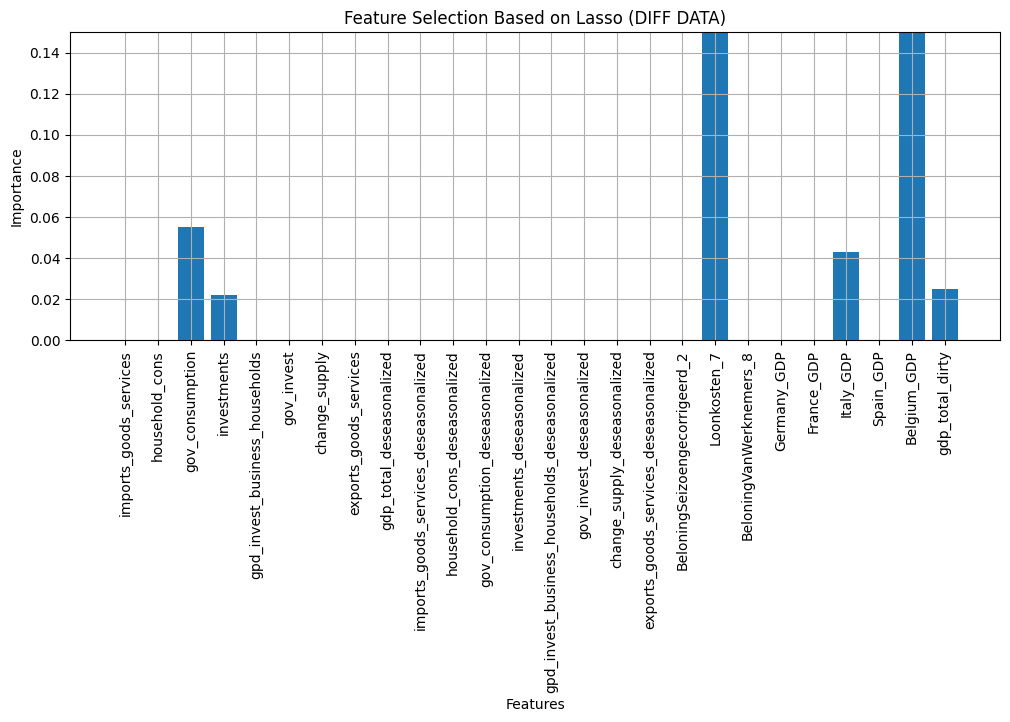

['gov_consumption',
 'investments',
 'gov_invest',
 'Loonkosten_7',
 'France_GDP',
 'Italy_GDP',
 'Belgium_GDP',
 'gdp_total_dirty']

In [130]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.01, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [131]:
scaled_features_df.head()

,gdp_total,imports_goods_services,household_cons,gov_consumption,investments,gpd_invest_business_households,gov_invest,change_supply,exports_goods_services,gdp_total_deseasonalized,...,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty
1995-01-01,-2.002523,-1.641276,-2.632058,-1.669821,-1.840331,-1.572989,-2.732067,-0.622509,-1.550755,NaN,...,NaN,-1.700671,-1.719203,NaN,-1.826380,-1.956485,NaN,-2.268526,-1.836933,-1.786714
1995-04-01,-1.973273,-1.587921,-2.525192,-1.448865,-1.479140,-1.258953,-2.202548,-1.535684,-1.563031,NaN,...,NaN,-1.662912,-1.370268,NaN,-1.751343,-1.904910,NaN,-1.965803,-1.653072,-1.961002
1995-07-01,-2.108767,-1.653600,-2.437948,-1.812432,-2.072665,-1.830188,-2.593081,0.613523,-1.632568,NaN,...,NaN,-1.637459,-1.681575,NaN,-1.621475,-2.148884,NaN,-2.141781,-1.831052,-2.089468
1995-10-01,-1.826802,-1.598566,-2.622014,-1.492912,-1.293918,-1.236942,-1.041717,1.083540,-1.579339,NaN,...,NaN,-1.602870,-1.572195,NaN,-1.494491,-1.787402,NaN,-1.775144,-1.536782,-1.890560
1996-01-01,-1.886039,-1.567974,-2.228187,-1.745279,-1.842434,-1.562888,-2.809391,-0.369036,-1.485913,-2.113368,...,-1.64059,-1.618999,-1.646859,0.21731,-1.848506,-1.874681,-2.499954,-2.154475,-1.785378,-2.048991


In [132]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty'] + selectThese 
df_lag = df[selectThese]

[ 0  3  8 10 16 19 20 22 24]
['gdp_total_dirty', 'household_cons_lag_1', 'change_supply_lag_1', 'gdp_total_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'BeloningSeizoengecorrigeerd_2_lag_1', 'Loonkosten_7_lag_1', 'Germany_GDP_lag_1', 'Italy_GDP_lag_1']


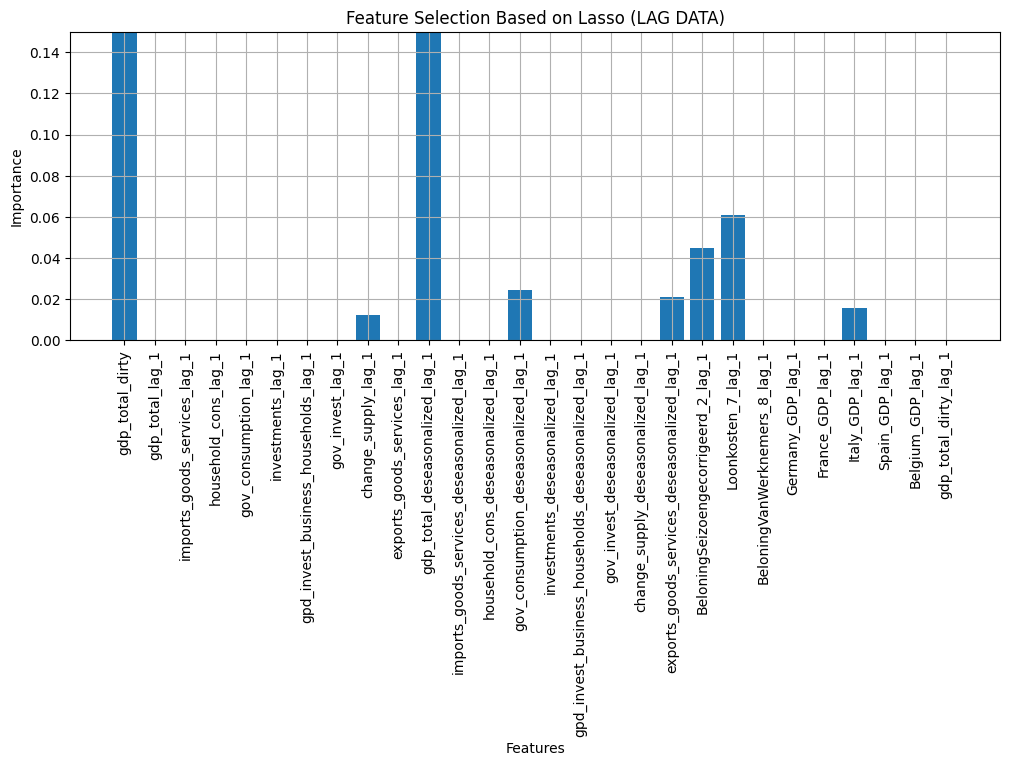

['gdp_total_dirty',
 'household_cons_lag_1',
 'change_supply_lag_1',
 'gdp_total_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'BeloningSeizoengecorrigeerd_2_lag_1',
 'Loonkosten_7_lag_1',
 'Germany_GDP_lag_1',
 'Italy_GDP_lag_1']

In [133]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  4 17 20]
['gdp_total_dirty', 'gov_consumption_lag_1', 'change_supply_deseasonalized_lag_1', 'Loonkosten_7_lag_1']


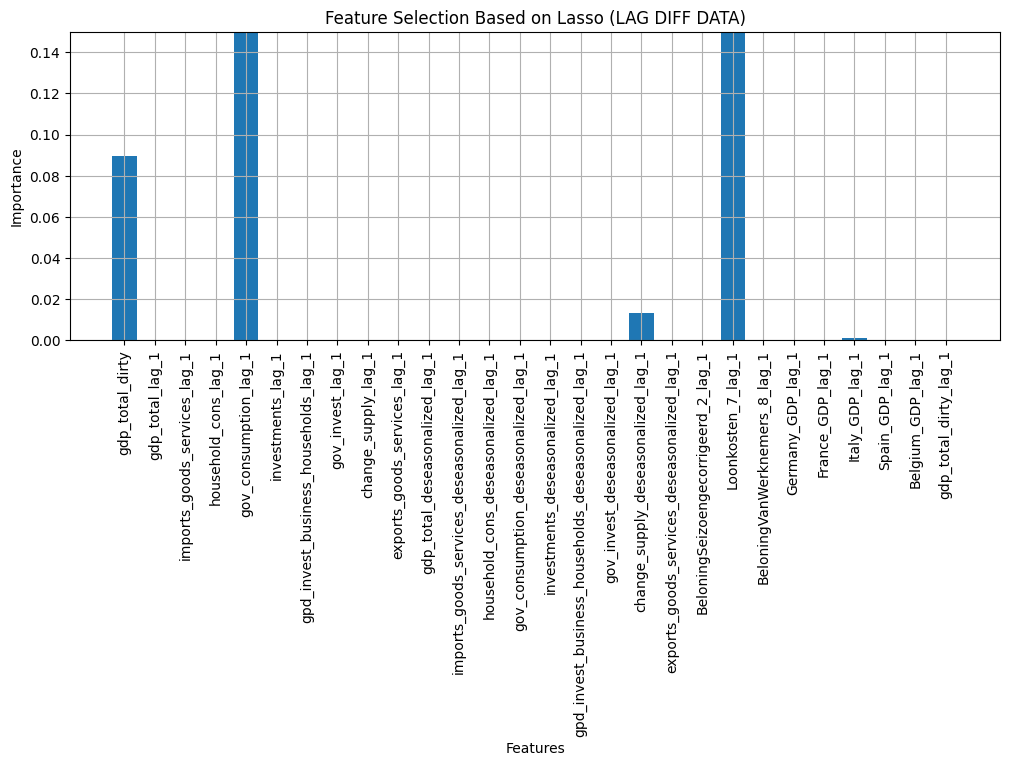

['gdp_total_dirty',
 'gov_consumption_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Loonkosten_7_lag_1']

In [134]:
lassoreg(df_lag.diff().dropna(), alpha=0.01, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 

### Make sure data is stationary

<Axes: >

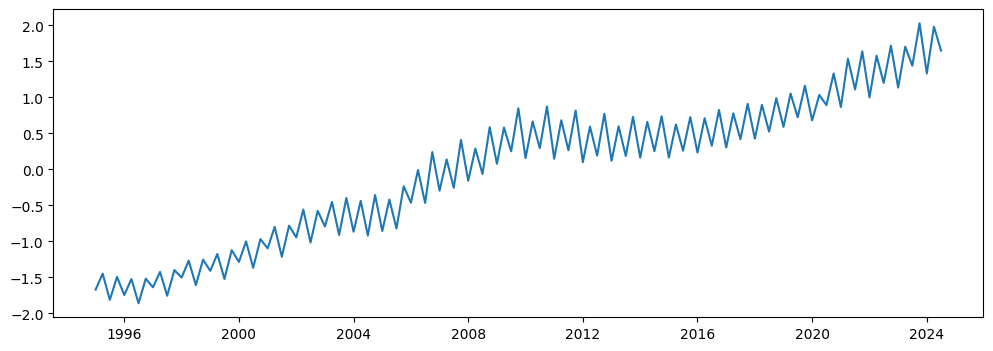

In [135]:
scaled_features_df['gov_consumption'].plot()

In [136]:
timeseries = scaled_features_df['gov_consumption']

In [137]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [138]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [139]:
def stationdarydf(mydata, save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
        else:
            stationary_features.append('NotStationary')
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df

#stationdarydf(scaled_features_df)

### If not stationary, difference, then test for stationarity again

replace in original data frame

In [140]:

def differenceData(originalData, mydiff=1):
    
    ## which features are not stationary
    # function from above
    stat1 = stationdarydf(originalData)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in stationarydf_diff:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        stationarydf_diff.rename(columns={col: col + "_diff"}, inplace=True)
    

    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff

scaled_features_df_diff = differenceData(scaled_features_df, mydiff=1)

In [141]:
stationdarydf(scaled_features_df_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,118
1,imports_goods_services_diff,Stationary,118
2,household_cons_diff,NotStationary,118
3,gov_consumption_diff,Stationary,118
4,investments_diff,Stationary,118
5,gpd_invest_business_households_diff,Stationary,118
6,gov_invest_diff,Stationary,118
7,change_supply_diff,Stationary,118
8,exports_goods_services_diff,Stationary,118
9,gdp_total_deseasonalized_diff,Stationary,114


<Axes: >

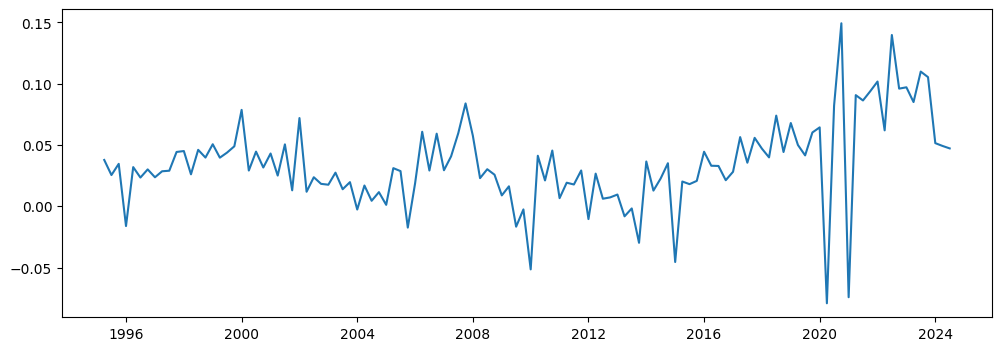

In [142]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2_diff'].plot()

[ 2  3  5 18 21 22 24 25]
['gov_consumption_diff', 'investments_diff', 'gov_invest_diff', 'Loonkosten_7_diff', 'France_GDP_diff', 'Italy_GDP_diff', 'Belgium_GDP_diff', 'gdp_total_dirty_diff']


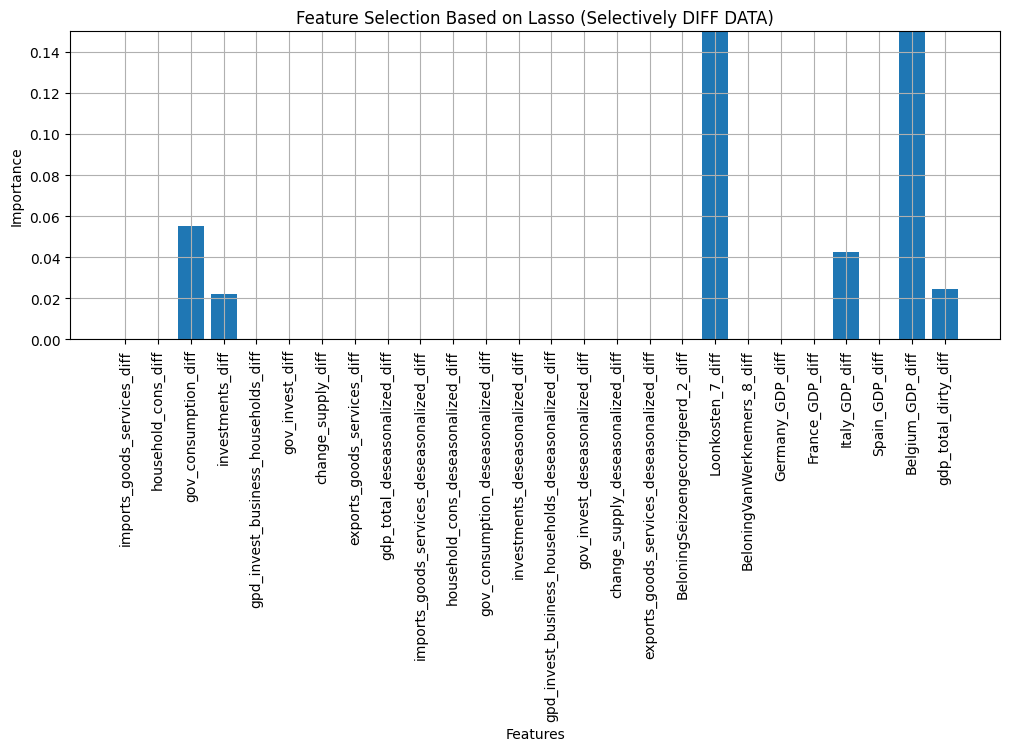

['gov_consumption_diff',
 'investments_diff',
 'gov_invest_diff',
 'Loonkosten_7_diff',
 'France_GDP_diff',
 'Italy_GDP_diff',
 'Belgium_GDP_diff',
 'gdp_total_dirty_diff']

In [143]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.01, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

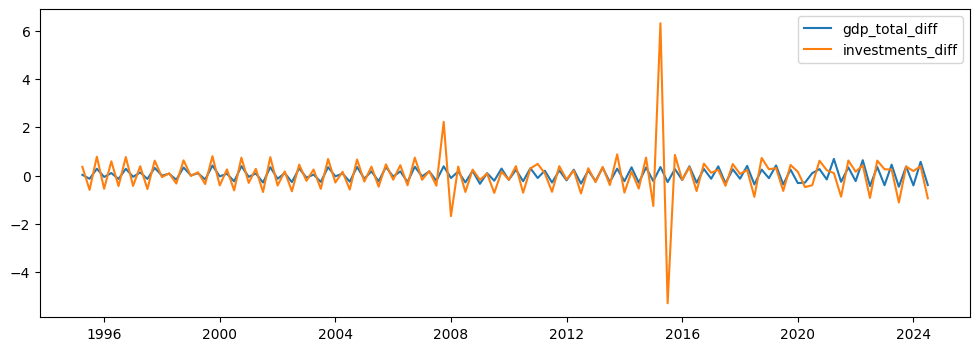

In [144]:
scaled_features_df_diff[['gdp_total_diff', 'investments_diff']].plot()

In [145]:

df_lag_diff = differenceData(df_lag, mydiff=1)
stationdarydf(df_lag_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,118
1,gdp_total_dirty_diff,Stationary,118
2,gdp_total_lag_1_diff,Stationary,117
3,imports_goods_services_lag_1_diff,Stationary,117
4,household_cons_lag_1_diff,NotStationary,117
5,gov_consumption_lag_1_diff,Stationary,117
6,investments_lag_1_diff,Stationary,117
7,gpd_invest_business_households_lag_1_diff,Stationary,117
8,gov_invest_lag_1_diff,Stationary,117
9,change_supply_lag_1_diff,Stationary,117


[ 0  4 17 20]
['gdp_total_dirty_diff', 'gov_consumption_lag_1_diff', 'change_supply_deseasonalized_lag_1_diff', 'Loonkosten_7_lag_1_diff']


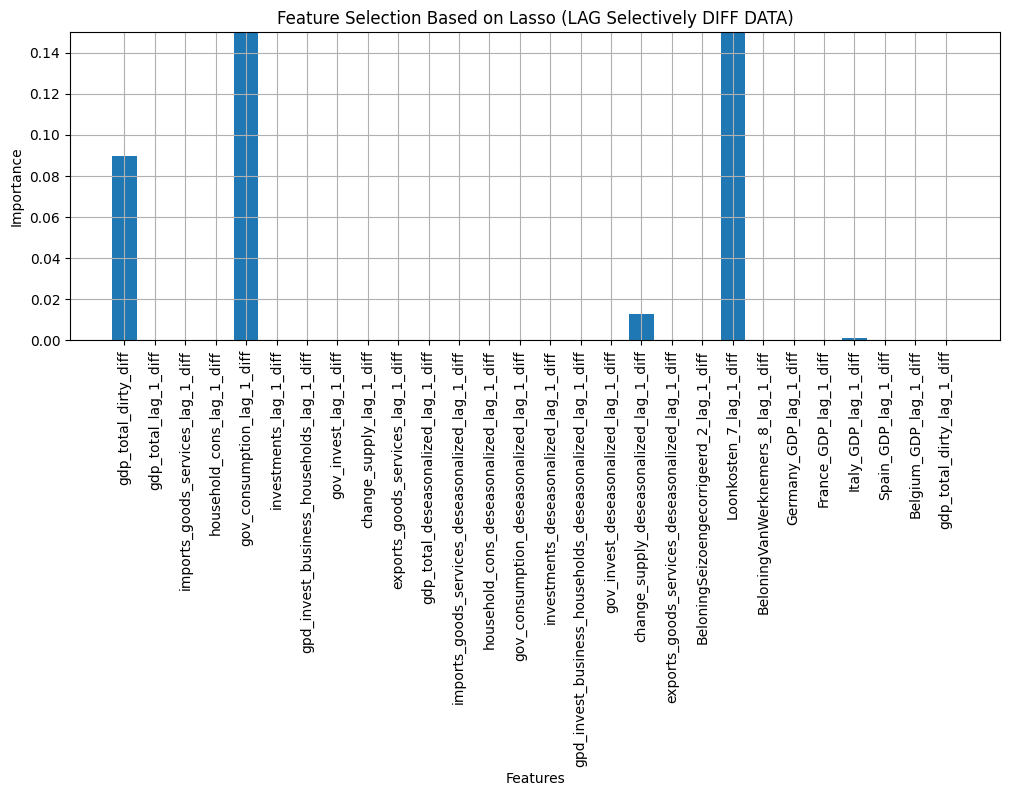

['gdp_total_dirty_diff',
 'gov_consumption_lag_1_diff',
 'change_supply_deseasonalized_lag_1_diff',
 'Loonkosten_7_lag_1_diff']

In [146]:
lassoreg(df_lag_diff.dropna(), alpha=0.01, title='Feature Selection Based on Lasso (LAG Selectively DIFF DATA)') 

In [147]:
df_lag_diff

,gdp_total_diff,gdp_total_dirty_diff,gdp_total_lag_1_diff,imports_goods_services_lag_1_diff,household_cons_lag_1_diff,gov_consumption_lag_1_diff,investments_lag_1_diff,gpd_invest_business_households_lag_1_diff,gov_invest_lag_1_diff,change_supply_lag_1_diff,...,exports_goods_services_deseasonalized_lag_1_diff,BeloningSeizoengecorrigeerd_2_lag_1_diff,Loonkosten_7_lag_1_diff,BeloningVanWerknemers_8_lag_1_diff,Germany_GDP_lag_1_diff,France_GDP_lag_1_diff,Italy_GDP_lag_1_diff,Spain_GDP_lag_1_diff,Belgium_GDP_lag_1_diff,gdp_total_dirty_lag_1_diff
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-01,0.029250,-0.174288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-01,-0.135493,-0.128466,0.029250,0.053355,0.106866,0.220956,0.361191,0.314036,0.529519,-0.913175,...,NaN,0.037759,0.348935,NaN,0.075037,0.051576,NaN,0.302723,0.183861,-0.174288
1995-10-01,0.281965,0.198908,-0.135493,-0.065679,0.087245,-0.363567,-0.593525,-0.571235,-0.390533,2.149208,...,NaN,0.025452,-0.311307,NaN,0.129869,-0.243975,NaN,-0.175978,-0.177980,-0.128466
1996-01-01,-0.059237,-0.158431,0.281965,0.055034,-0.184066,0.319520,0.778747,0.593246,1.551364,0.470017,...,NaN,0.034589,0.109381,NaN,0.126984,0.361483,NaN,0.366638,0.294269,0.198908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.464870,-0.598024,0.449766,0.051030,0.217235,0.566953,0.249300,0.241671,0.170307,0.782242,...,-0.078359,0.084981,0.863398,-0.038959,-0.253004,0.086457,0.479123,0.328137,0.370663,0.318922
2023-10-01,0.375241,0.053331,-0.464870,-0.186057,-0.145875,-0.262837,-1.115962,-1.225540,0.164435,-0.046442,...,-0.120684,0.109828,-0.875000,-0.272714,0.166424,-0.191863,0.041630,-0.049543,-0.577252,-0.598024
2024-01-01,-0.409280,-0.004096,0.375241,0.062889,-0.165146,0.588856,0.370445,0.385648,0.082217,0.784480,...,0.091815,0.105306,0.663155,0.077918,0.198171,0.538545,0.271398,0.370943,0.847349,0.053331
2024-04-01,0.568497,0.619237,-0.409280,-0.104436,0.251806,-0.697649,0.184942,0.307855,-0.704720,-1.932105,...,-0.058421,0.051479,-0.290484,-0.022727,-0.145261,-0.265230,-0.784049,-0.386379,-0.578013,-0.004096
